## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [7]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


In [8]:
## Load in the data set (Internet Access needed)

##url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('pima-indians-diabetes.data', names=names)

In [9]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
332,1,180,0,0,0,43.3,0.282,41,1
106,1,96,122,0,0,22.4,0.207,27,0
99,1,122,90,51,220,49.7,0.325,31,1
674,8,91,82,0,0,35.6,0.587,68,0
678,3,121,52,0,0,36.0,0.127,25,1


In [10]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [11]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [12]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [13]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [16]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)





print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.828


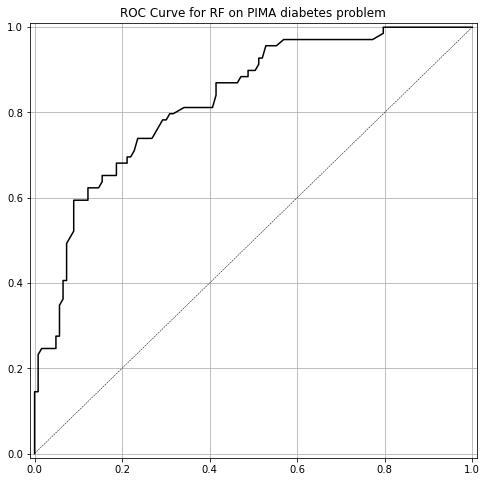

In [17]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [18]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [19]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [20]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [21]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 3s 10ms/step - loss: 0.7284 - accuracy: 0.5556 - val_loss: 0.7423 - val_accuracy: 0.5938
Epoch 2/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7234 - accuracy: 0.5538 - val_loss: 0.7372 - val_accuracy: 0.5885
Epoch 3/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7186 - accuracy: 0.5556 - val_loss: 0.7323 - val_accuracy: 0.5885
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7139 - accuracy: 0.5642 - val_loss: 0.7275 - val_accuracy: 0.5885
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7093 - accuracy: 0.5694 - val_loss: 0.7228 - val_accuracy: 0.5938
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7049 - accuracy: 0.5747 - val_loss: 0.7183 - val_accuracy: 0.5938
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.5833 - val_loss: 0.7140 - val_accuracy: 0.5938
Epoch 8/200


Epoch 59/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5692 - accuracy: 0.7014 - val_loss: 0.5929 - val_accuracy: 0.6719
Epoch 60/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7083 - val_loss: 0.5915 - val_accuracy: 0.6719
Epoch 61/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.7101 - val_loss: 0.5902 - val_accuracy: 0.6719
Epoch 62/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5644 - accuracy: 0.7135 - val_loss: 0.5889 - val_accuracy: 0.6719
Epoch 63/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.7153 - val_loss: 0.5876 - val_accuracy: 0.6719
Epoch 64/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.7153 - val_loss: 0.5863 - val_accuracy: 0.6719
Epoch 65/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.7135 - val_loss: 0.5850 - val_accuracy: 0.6771
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5055 - accuracy: 0.7691 - val_loss: 0.5447 - val_accuracy: 0.7396
Epoch 117/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7691 - val_loss: 0.5442 - val_accuracy: 0.7448
Epoch 118/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.7674 - val_loss: 0.5438 - val_accuracy: 0.7500
Epoch 119/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5033 - accuracy: 0.7691 - val_loss: 0.5433 - val_accuracy: 0.7552
Epoch 120/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5026 - accuracy: 0.7691 - val_loss: 0.5428 - val_accuracy: 0.7552
Epoch 121/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5018 - accuracy: 0.7691 - val_loss: 0.5424 - val_accuracy: 0.7552
Epoch 122/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5012 - accuracy: 0.7674 - val_loss: 0.5420 - val_accuracy: 0.7552
Epoch 123/200

18/18 [==============================] - 0s 2ms/step - loss: 0.4759 - accuracy: 0.7656 - val_loss: 0.5260 - val_accuracy: 0.7708
Epoch 174/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4756 - accuracy: 0.7674 - val_loss: 0.5258 - val_accuracy: 0.7708
Epoch 175/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.7674 - val_loss: 0.5256 - val_accuracy: 0.7708
Epoch 176/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.7691 - val_loss: 0.5255 - val_accuracy: 0.7708
Epoch 177/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4746 - accuracy: 0.7691 - val_loss: 0.5253 - val_accuracy: 0.7708
Epoch 178/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7691 - val_loss: 0.5251 - val_accuracy: 0.7708
Epoch 179/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4740 - accuracy: 0.7691 - val_loss: 0.5249 - val_accuracy: 0.7708
Epoch 180/200

In [25]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

#y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
#y_pred_prob_nn_1 = model_1.predict(X_test_norm)

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype("int32")

#O método "predict_classes" não funciona nas versões do Keras superior a 2.5 

# A indicação da correção se encontra em https://keras.rstudio.com/reference/predict_proba.html#details. 



In [26]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [27]:
y_pred_prob_nn_1[:10]

array([[0.61289346],
       [0.82188576],
       [0.25061363],
       [0.27771303],
       [0.18991533],
       [0.52391744],
       [0.06130368],
       [0.3522847 ],
       [0.7077393 ],
       [0.17696917]], dtype=float32)

accuracy is 0.771
roc-auc is 0.800


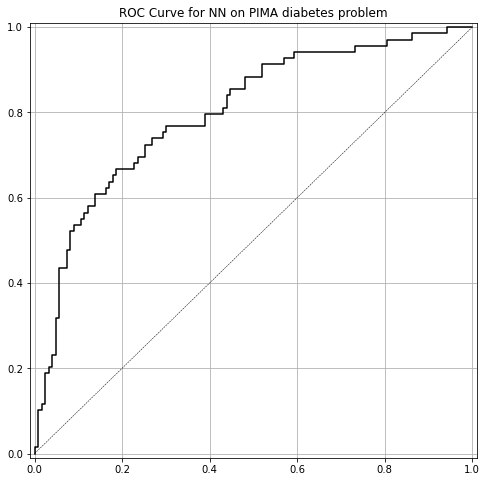

In [28]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [29]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

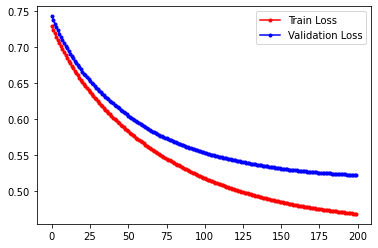

In [30]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [31]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4680 - accuracy: 0.7691 - val_loss: 0.5222 - val_accuracy: 0.7708
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7691 - val_loss: 0.5221 - val_accuracy: 0.7708
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7691 - val_loss: 0.5220 - val_accuracy: 0.7708
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4673 - accuracy: 0.7691 - val_loss: 0.5219 - val_accuracy: 0.7708
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4671 - accuracy: 0.7691 - val_loss: 0.5218 - val_accuracy: 0.7708
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.7691 - val_loss: 0.5217 - val_accuracy: 0.7656
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7691 - val_loss: 0.5217 - val_accuracy: 0.7656
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7743 - val_loss: 0.5182 - val_accuracy: 0.7656
Epoch 59/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7760 - val_loss: 0.5182 - val_accuracy: 0.7656
Epoch 60/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.7743 - val_loss: 0.5181 - val_accuracy: 0.7656
Epoch 61/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7726 - val_loss: 0.5181 - val_accuracy: 0.7656
Epoch 62/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7726 - val_loss: 0.5180 - val_accuracy: 0.7708
Epoch 63/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7726 - val_loss: 0.5180 - val_accuracy: 0.7708
Epoch 64/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4570 - accuracy: 0.7726 - val_loss: 0.5179 - val_accuracy: 0.7708
Epoch 65/1000

18/18 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.7743 - val_loss: 0.5160 - val_accuracy: 0.7656
Epoch 116/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7743 - val_loss: 0.5160 - val_accuracy: 0.7656
Epoch 117/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.7760 - val_loss: 0.5160 - val_accuracy: 0.7708
Epoch 118/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.7760 - val_loss: 0.5159 - val_accuracy: 0.7708
Epoch 119/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7760 - val_loss: 0.5159 - val_accuracy: 0.7708
Epoch 120/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.7743 - val_loss: 0.5159 - val_accuracy: 0.7708
Epoch 121/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4511 - accuracy: 0.7760 - val_loss: 0.5159 - val_accuracy: 0.7708
Epoch 1

Epoch 172/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4476 - accuracy: 0.7812 - val_loss: 0.5148 - val_accuracy: 0.7708
Epoch 173/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4475 - accuracy: 0.7795 - val_loss: 0.5148 - val_accuracy: 0.7708
Epoch 174/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4475 - accuracy: 0.7795 - val_loss: 0.5147 - val_accuracy: 0.7708
Epoch 175/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.7812 - val_loss: 0.5147 - val_accuracy: 0.7708
Epoch 176/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.7778 - val_loss: 0.5147 - val_accuracy: 0.7708
Epoch 177/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7795 - val_loss: 0.5147 - val_accuracy: 0.7708
Epoch 178/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7795 - val_loss: 0.5147 - val_accuracy:

Epoch 229/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.7778 - val_loss: 0.5138 - val_accuracy: 0.7708
Epoch 230/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7778 - val_loss: 0.5138 - val_accuracy: 0.7708
Epoch 231/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7778 - val_loss: 0.5138 - val_accuracy: 0.7708
Epoch 232/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7778 - val_loss: 0.5138 - val_accuracy: 0.7708
Epoch 233/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7778 - val_loss: 0.5137 - val_accuracy: 0.7708
Epoch 234/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7778 - val_loss: 0.5137 - val_accuracy: 0.7708
Epoch 235/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4443 - accuracy: 0.7778 - val_loss: 0.5137 - val_accuracy:

18/18 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7708
Epoch 286/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7708
Epoch 287/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7708
Epoch 288/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7708
Epoch 289/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7708
Epoch 290/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.7778 - val_loss: 0.5123 - val_accuracy: 0.7708
Epoch 291/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4416 - accuracy: 0.7778 - val_loss: 0.5123 - val_accuracy: 0.7708
Epoch 2

Epoch 342/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4397 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7760
Epoch 343/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7760
Epoch 344/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7760
Epoch 345/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7760
Epoch 346/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7760
Epoch 347/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7760 - val_loss: 0.5112 - val_accuracy: 0.7760
Epoch 348/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7760 - val_loss: 0.5112 - val_accuracy:

Epoch 399/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7760 - val_loss: 0.5104 - val_accuracy: 0.7812
Epoch 400/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7760 - val_loss: 0.5104 - val_accuracy: 0.7812
Epoch 401/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7760 - val_loss: 0.5104 - val_accuracy: 0.7812
Epoch 402/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy: 0.7812
Epoch 403/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy: 0.7812
Epoch 404/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy: 0.7812
Epoch 405/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy:

Epoch 456/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4360 - accuracy: 0.7795 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 457/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7795 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 458/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7795 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 459/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7795 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 460/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7778 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 461/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7778 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 462/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7795 - val_loss: 0.5095 - val_accuracy:

Epoch 513/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7812
Epoch 514/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7812
Epoch 515/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7812
Epoch 516/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7812
Epoch 517/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7812
Epoch 518/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy: 0.7812
Epoch 519/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy:

Epoch 570/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.7847 - val_loss: 0.5088 - val_accuracy: 0.7812
Epoch 571/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7830 - val_loss: 0.5088 - val_accuracy: 0.7812
Epoch 572/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.7830 - val_loss: 0.5088 - val_accuracy: 0.7865
Epoch 573/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7847 - val_loss: 0.5087 - val_accuracy: 0.7865
Epoch 574/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7847 - val_loss: 0.5087 - val_accuracy: 0.7865
Epoch 575/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7847 - val_loss: 0.5087 - val_accuracy: 0.7865
Epoch 576/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7847 - val_loss: 0.5087 - val_accuracy:

Epoch 627/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7830 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 628/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 629/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 630/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 631/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 632/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 633/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy:

Epoch 684/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 685/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 686/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 687/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 688/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 689/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 690/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.4301 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy:

Epoch 741/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 742/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 743/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 744/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 745/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 746/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 747/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy:

Epoch 798/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.7917 - val_loss: 0.5094 - val_accuracy: 0.7812
Epoch 799/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.7917 - val_loss: 0.5094 - val_accuracy: 0.7812
Epoch 800/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.7917 - val_loss: 0.5094 - val_accuracy: 0.7812
Epoch 801/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7812
Epoch 802/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7812
Epoch 803/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7812
Epoch 804/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy:

Epoch 855/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.7917 - val_loss: 0.5100 - val_accuracy: 0.7812
Epoch 856/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7934 - val_loss: 0.5100 - val_accuracy: 0.7812
Epoch 857/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7934 - val_loss: 0.5100 - val_accuracy: 0.7812
Epoch 858/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7934 - val_loss: 0.5101 - val_accuracy: 0.7812
Epoch 859/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7934 - val_loss: 0.5101 - val_accuracy: 0.7812
Epoch 860/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7934 - val_loss: 0.5101 - val_accuracy: 0.7812
Epoch 861/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.7934 - val_loss: 0.5101 - val_accuracy:

Epoch 912/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0.5108 - val_accuracy: 0.7812
Epoch 913/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5108 - val_accuracy: 0.7812
Epoch 914/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5109 - val_accuracy: 0.7812
Epoch 915/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5109 - val_accuracy: 0.7812
Epoch 916/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5109 - val_accuracy: 0.7812
Epoch 917/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5109 - val_accuracy: 0.7812
Epoch 918/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5109 - val_accuracy:

Epoch 969/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.5115 - val_accuracy: 0.7812
Epoch 970/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7951 - val_loss: 0.5116 - val_accuracy: 0.7812
Epoch 971/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.5116 - val_accuracy: 0.7812
Epoch 972/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7934 - val_loss: 0.5116 - val_accuracy: 0.7812
Epoch 973/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7934 - val_loss: 0.5116 - val_accuracy: 0.7812
Epoch 974/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7934 - val_loss: 0.5116 - val_accuracy: 0.7812
Epoch 975/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7934 - val_loss: 0.5116 - val_accuracy:

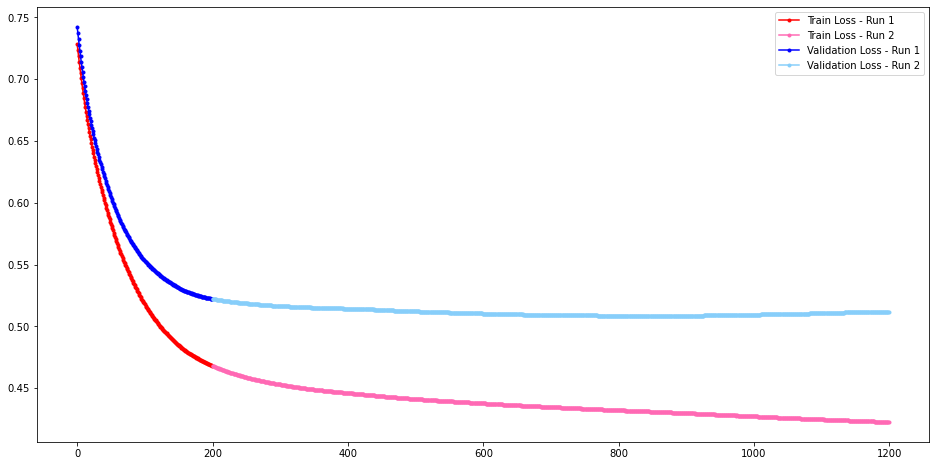

In [32]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures